# Load the data

In [1]:
#Processing
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score
import gc
import seaborn as sns
#Plotting
import matplotlib.pyplot as plt

#Models
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('challenge2_train.csv')
test = pd.read_csv('challenge2_test.csv')

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   target  50000 non-null  int64  
 2   f0      45122 non-null  float64
 3   f1      50000 non-null  int64  
 4   f2      48816 non-null  float64
 5   f3      49677 non-null  float64
 6   f4      46621 non-null  object 
 7   f5      26130 non-null  float64
 8   f6      46648 non-null  float64
 9   f7      49517 non-null  float64
 10  f8      48540 non-null  object 
 11  f9      49497 non-null  float64
 12  f10     28585 non-null  float64
 13  f11     49894 non-null  float64
 14  f12     48487 non-null  object 
 15  f13     49497 non-null  float64
 16  f14     29937 non-null  float64
 17  f15     49057 non-null  float64
 18  f16     49020 non-null  float64
 19  f17     48630 non-null  object 
 20  f18     48749 non-null  float64
 21  f19     45121 non-null  float64
 22

In [4]:
X_train = train.drop(["id", "target"], axis=1)
Y_train = train["target"].values

In [5]:
X_test = test.drop(["id"], axis=1)

In [6]:
X_train.shape

(50000, 25)

In [7]:
Y_train.shape

(50000,)

In [8]:
X_test.shape

(50000, 25)

# Preprocessing the data

## Prepare data

### Remove duplicate rows

In [9]:
X_train = X_train.drop_duplicates()
X_train.shape

(50000, 25)

### Remove null values

In [10]:
X_train.isnull().sum()

f0      4878
f1         0
f2      1184
f3       323
f4      3379
f5     23870
f6      3352
f7       483
f8      1460
f9       503
f10    21415
f11      106
f12     1513
f13      503
f14    20063
f15      943
f16      980
f17     1370
f18     1251
f19     4879
f20    18755
f21     3584
f22      254
f23    24840
f24      602
dtype: int64

For the XGBoost algorithm, we do not need to remove the null variables as these will be handled as "missing". However, for other algorithms we might need to imputate them with e.g. the mean of the feature, as in the commented code below:

In [11]:
#for col in X_train.columns:
#    values = X_train[col]
#    if values.dtype in ['int', 'float']:
#        values_mean = values.mean()
#        values.fillna(values_mean, inplace=True)

#X_train.isnull().sum()

In [46]:
X_train.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998,
            49999],
           dtype='int64', length=50000)

In [47]:
X_train.dtypes

f0         float64
f1           int64
f2         float64
f3         float64
f5         float64
            ...   
f21_nx       uint8
f21_x        uint8
f21_xbx      uint8
f21_xnx      uint8
f12_dec    float64
Length: 84, dtype: object

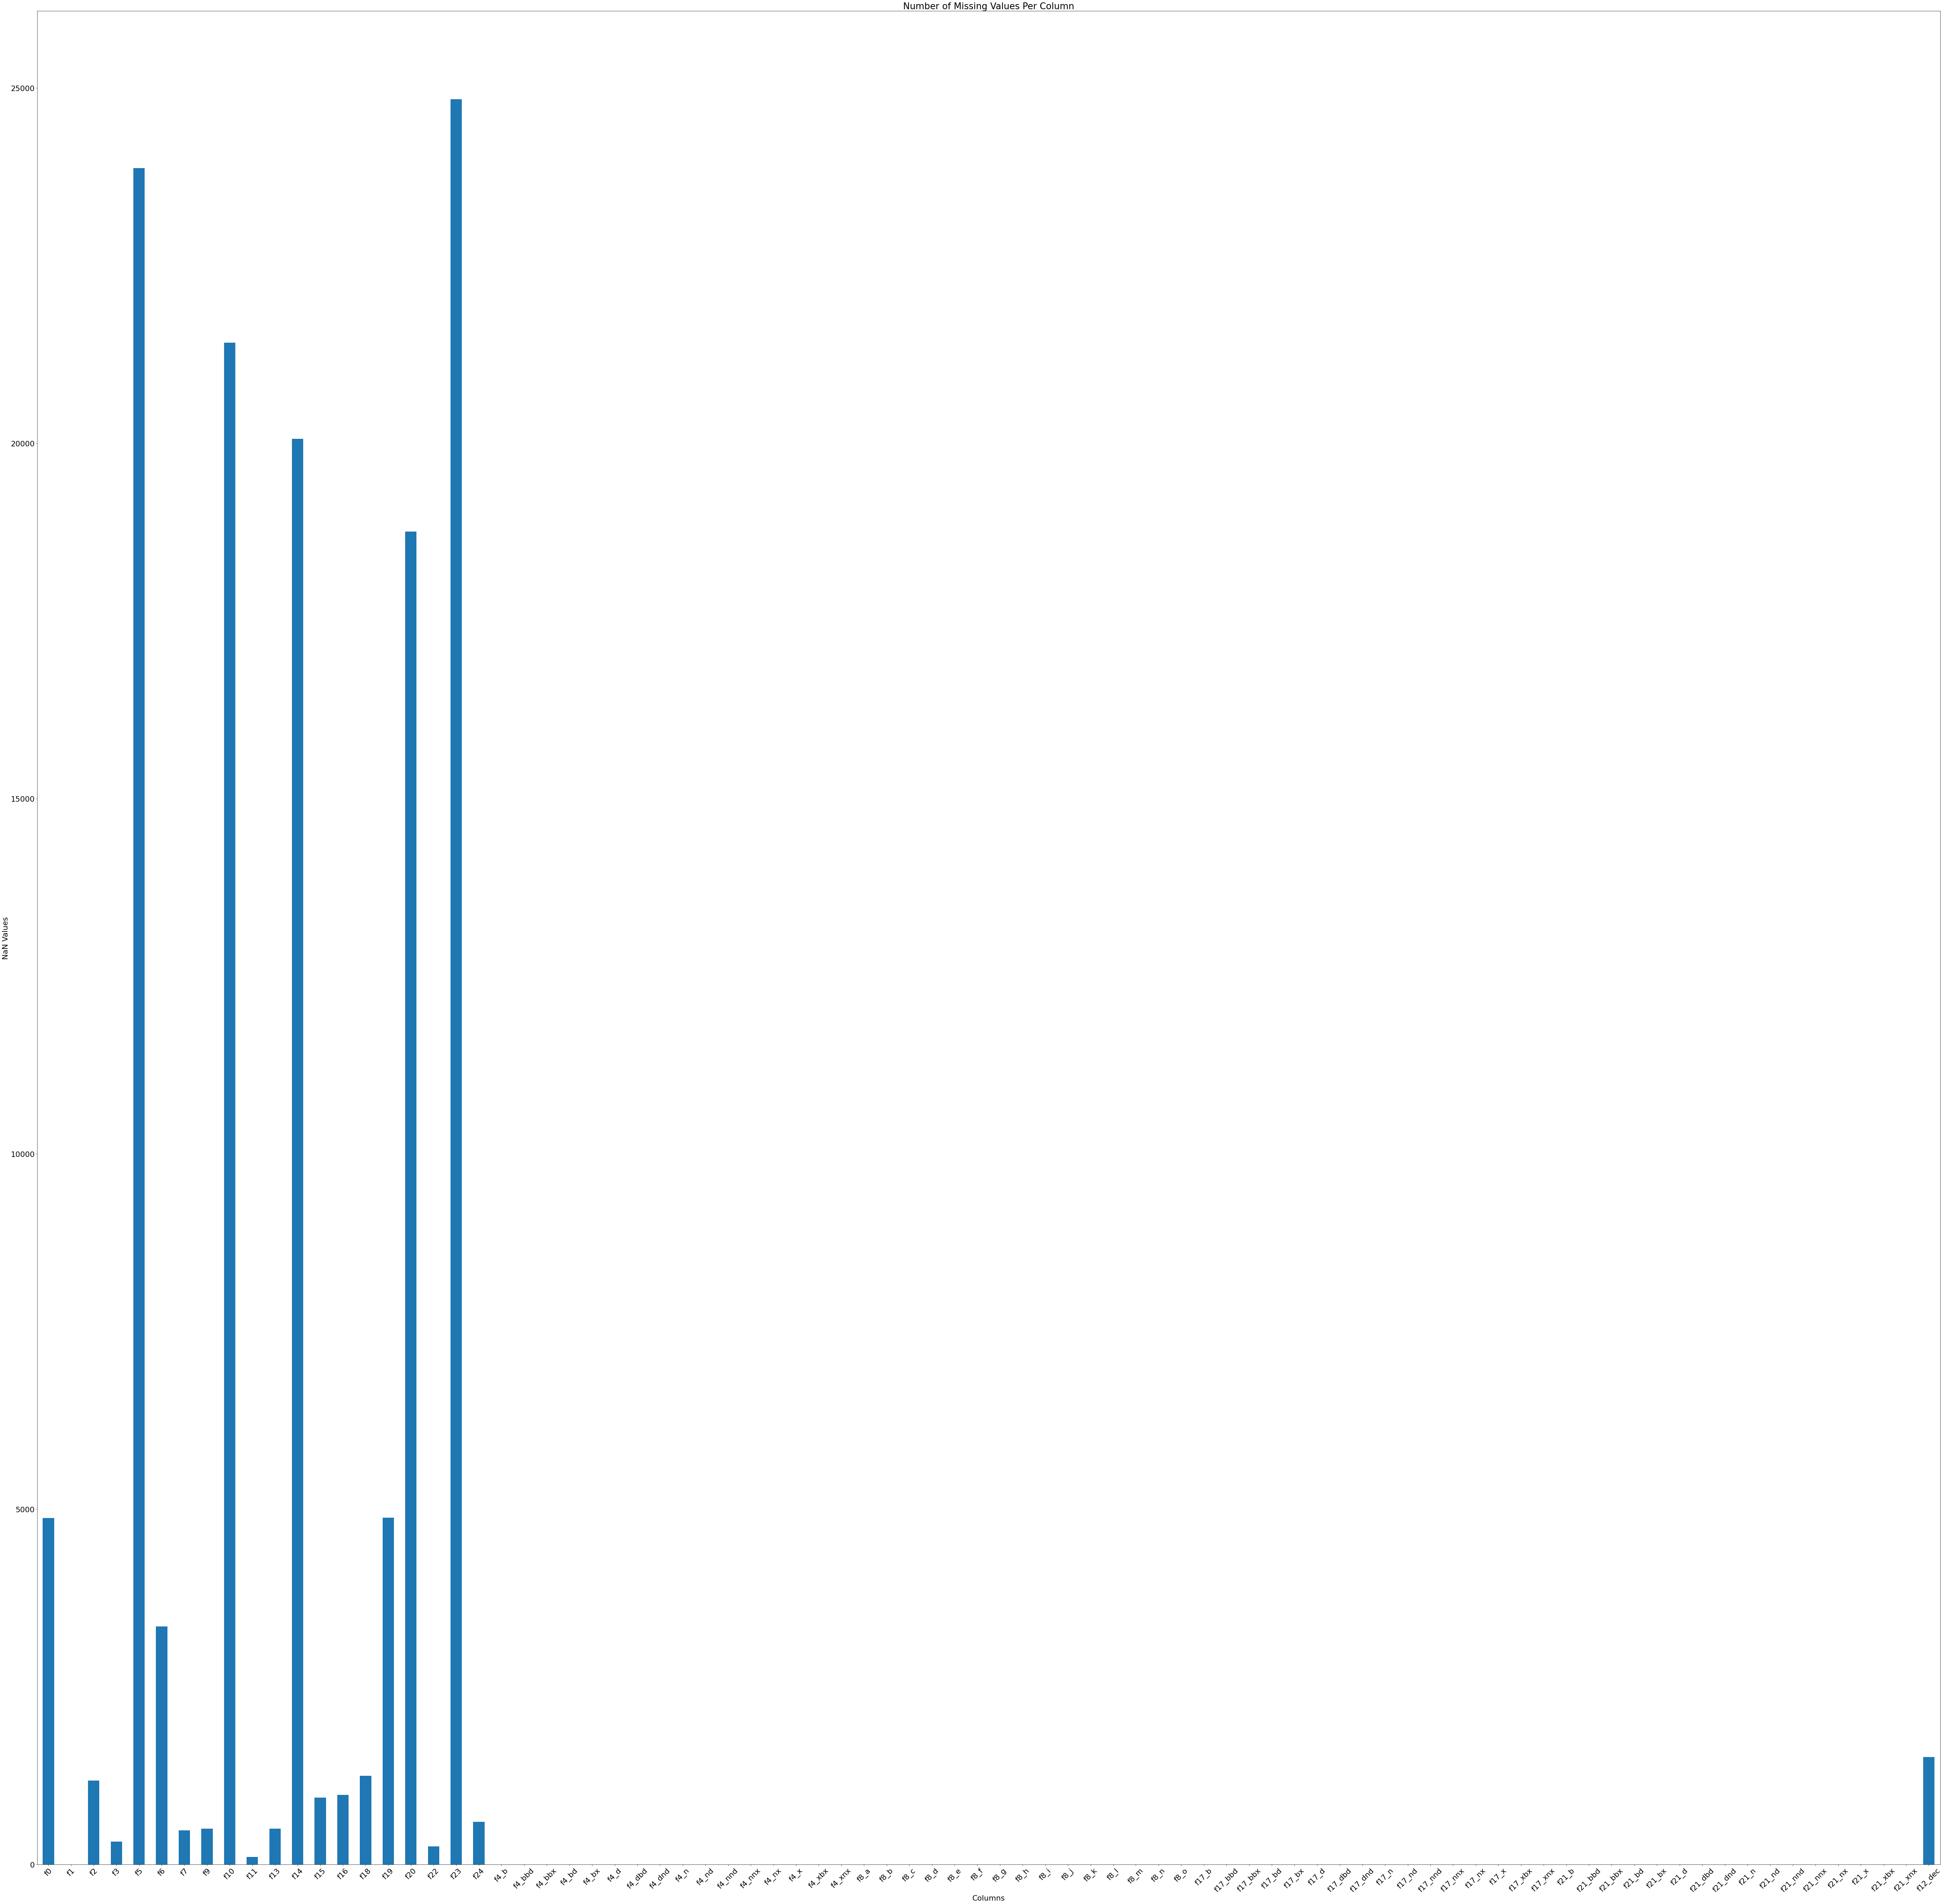

In [50]:
# plot missing data:
X_train.isnull().sum().plot(kind='bar')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column')
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 45)
# Create X axis label.
plt.xlabel("Columns")
# Create Y axis label.
plt.ylabel("NaN Values");

## Understanding the variables

In [12]:
X_train.describe()

,f0,f1,f2,f3,f5,f6,f7,f9,f10,f11,f13,f14,f15,f16,f18,f19,f20,f22,f23,f24
count,45122.000000,50000.00000,48816.000000,49677.000000,26130.000000,46648.000000,49517.000000,49497.000000,28585.000000,49894.00000,49497.000000,29937.000000,49057.000000,49020.000000,48749.000000,45121.000000,31245.000000,49746.000000,25160.000000,49398.000000
mean,1017.678647,23.49612,5.018887,16.998782,7.628550,40.050999,14.000848,0.222862,5.463607,23.23301,2.379215,4.508668,18.686630,21.683570,7.305524,1015.285913,4.428837,12.191203,52.013712,68.806470
std,7.130390,14.01738,0.007177,6.520973,3.776794,13.655620,8.936280,0.416171,4.251483,7.15277,8.795403,2.717503,8.842879,6.970918,3.546719,7.057875,2.884968,6.414481,8.323467,19.024988
min,982.000000,0.00000,4.998000,-6.200000,0.000000,7.000000,0.000000,0.000000,0.000000,-4.10000,0.000000,0.000000,0.000000,-5.100000,0.000000,978.200000,0.000000,-8.500000,37.000000,1.000000
25%,1013.000000,11.00000,5.014000,12.300000,4.900000,31.000000,7.000000,0.000000,2.600000,17.90000,0.000000,2.000000,13.000000,16.600000,5.000000,1010.500000,1.000000,7.600000,45.000000,57.000000
50%,1017.600000,23.00000,5.019100,16.700000,8.500000,39.000000,13.000000,0.000000,4.800000,22.60000,0.000000,5.000000,19.000000,21.100000,7.000000,1015.300000,5.000000,12.000000,52.000000,70.000000
75%,1022.500000,35.00000,5.024100,21.600000,10.600000,48.000000,19.000000,0.000000,7.400000,28.30000,0.800000,7.000000,24.000000,26.500000,10.000000,1020.100000,7.000000,16.900000,59.000000,83.000000
max,1040.900000,48.00000,5.045800,39.100000,14.300000,130.000000,87.000000,1.000000,145.000000,46.80000,371.000000,9.000000,87.000000,46.100000,13.000000,1038.500000,9.000000,33.900000,66.000000,100.000000


From the `.info()` call, we know what that some of the features include categorical data. We want to figure out how many categories each feature includes.

In [13]:
X_train['f4'].describe()

count     46621
unique       16
top           x
freq       3410
Name: f4, dtype: object

In [14]:
X_train['f8'].describe()

count     48540
unique       15
top           n
freq       5845
Name: f8, dtype: object

In [15]:
X_train['f17'].describe()

count     48630
unique       16
top          nd
freq       3762
Name: f17, dtype: object

In [16]:
X_train['f21'].describe()

count     46416
unique       16
top           b
freq       3996
Name: f21, dtype: object

One of the features, f12, consists of hex values

In [17]:
X_train['f12'].describe()

count         48487
unique         1206
top       360a16627
freq             98
Name: f12, dtype: object

<AxesSubplot:>

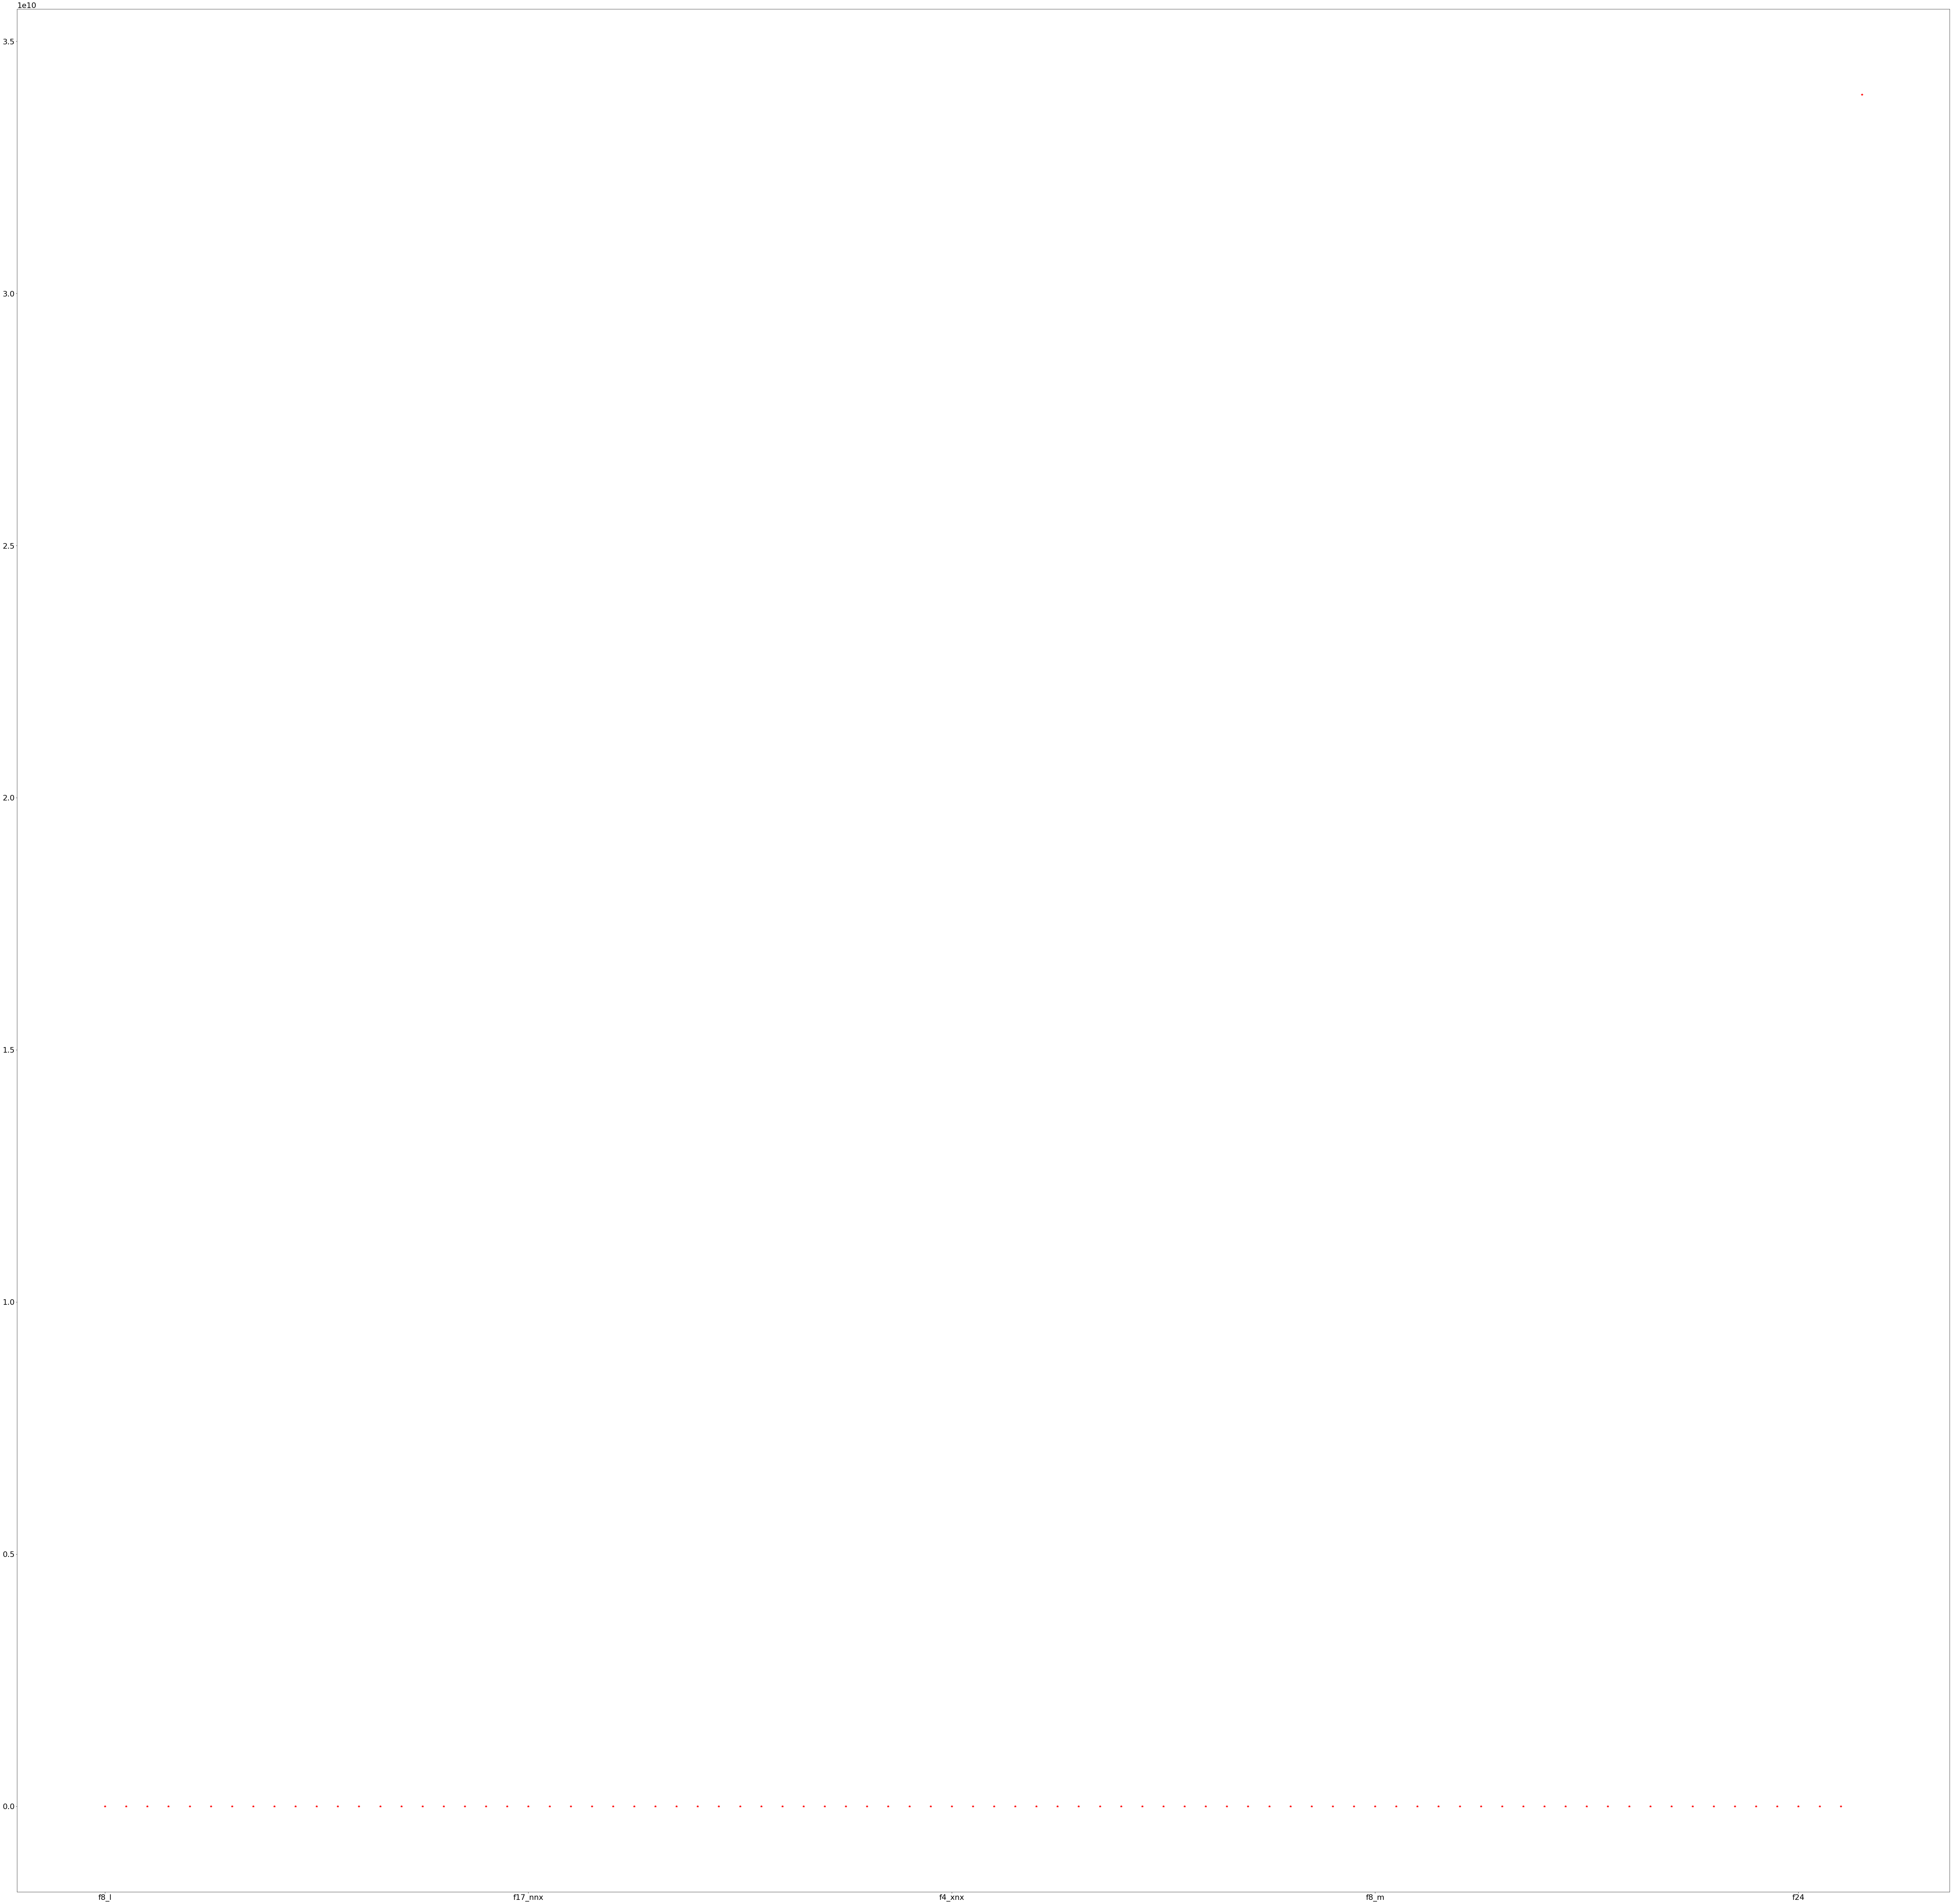

In [55]:
X_train.mean().sort_values().plot(style='*', color='red')

## Finding correlations between variables

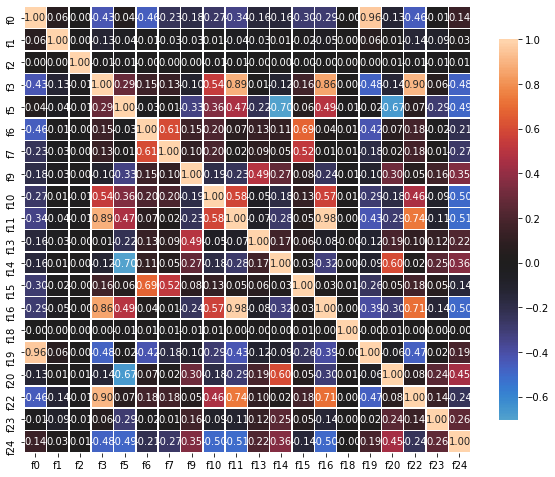

In [18]:
correlations = X_train.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
        square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

This table has some interesting information. Many of the features are highly correlated, like for instance

f0 - **f19**

f3 - f11, f16, **f22**

f5 - f14, f20

f6 - f7, f15

f7 - f15

f9 - f13

f11 - **f16**, f22, f24

f14 - f20

f16 - f22

For tree ensemble methods like XGBoost, however, multicollinearity between features does not affect the result considerably because this method does not find linear relationships between variables. So we are good for now...

## Encoding features

We need to One Hot Encode the categorical data, and also convert the hex values to decimal numbers

In [19]:
# Define which columns include categorical data
cat_cols = ['f4', 'f8', 'f17', 'f21']

# Columns containing hex values
hex_col = 'f12'

In [20]:
for i in cat_cols:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix=i)],axis=1)
    X_train.drop([i],axis=1, inplace=True)

In [21]:
X_train.head()

,f0,f1,f2,f3,f5,f6,f7,f9,f10,f11,...,f21_dbd,f21_dnd,f21_n,f21_nd,f21_nnd,f21_nnx,f21_nx,f21_x,f21_xbx,f21_xnx
0,1013.1,0,5.0190,26.1,11.1,33.0,11.0,0.0,3.6,29.0,...,0,0,0,1,0,0,0,0,0,0
1,1010.2,1,5.0142,10.4,NaN,46.0,17.0,0.0,0.8,14.4,...,0,0,0,0,0,0,1,0,0,0
2,1014.4,2,5.0280,12.3,NaN,31.0,13.0,1.0,NaN,15.4,...,0,0,0,0,0,0,1,0,0,0
3,1019.2,3,5.0335,23.0,11.6,41.0,9.0,0.0,8.0,33.4,...,0,1,0,0,0,0,0,0,0,0
4,1027.6,4,5.0129,7.3,7.3,28.0,15.0,1.0,0.2,14.3,...,1,0,0,0,0,0,0,0,0,0


In [22]:
for i in cat_cols:
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix=i)],axis=1)
    X_test.drop([i],axis=1, inplace=True)

In [23]:
X_test.head()

,f0,f1,f2,f3,f5,f6,f7,f9,f10,f11,...,f21_dbd,f21_dnd,f21_n,f21_nd,f21_nnd,f21_nnx,f21_nx,f21_x,f21_xbx,f21_xnx
0,1024.4,15,5.0256,6.6,0.8,20.0,2.0,0.0,0.2,11.6,...,0,0,0,0,0,0,0,0,0,0
1,1029.0,3,5.0289,5.6,9.0,28.0,0.0,0.0,1.8,14.8,...,0,0,0,0,0,0,0,0,0,0
2,1016.7,10,5.0081,22.3,NaN,31.0,6.0,0.0,NaN,34.3,...,0,0,0,0,0,0,0,0,0,0
3,1009.3,33,5.0168,11.3,NaN,31.0,11.0,1.0,NaN,16.2,...,0,1,0,0,0,0,0,0,0,0
4,1027.1,37,5.0205,12.6,12.6,22.0,6.0,0.0,5.0,22.3,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_train['f12_dec'] = X_train[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))
X_test['f12_dec'] = X_test[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))

In [25]:
X_train.drop([hex_col],axis=1, inplace=True)
X_test.drop([hex_col],axis=1, inplace=True)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 84 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       45122 non-null  float64
 1   f1       50000 non-null  int64  
 2   f2       48816 non-null  float64
 3   f3       49677 non-null  float64
 4   f5       26130 non-null  float64
 5   f6       46648 non-null  float64
 6   f7       49517 non-null  float64
 7   f9       49497 non-null  float64
 8   f10      28585 non-null  float64
 9   f11      49894 non-null  float64
 10  f13      49497 non-null  float64
 11  f14      29937 non-null  float64
 12  f15      49057 non-null  float64
 13  f16      49020 non-null  float64
 14  f18      48749 non-null  float64
 15  f19      45121 non-null  float64
 16  f20      31245 non-null  float64
 17  f22      49746 non-null  float64
 18  f23      25160 non-null  float64
 19  f24      49398 non-null  float64
 20  f4_b     50000 non-null  uint8  
 21  f4_bbd   500

# Save the data to csv files

In [27]:
X_train.to_csv('prepared_train_data.csv')

In [28]:
X_test.to_csv('prepared_test_data.csv')

# Create a model and predict

## xgboost.XGBClassifier from scikit-learn

In [29]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_tr, X_te, y_tr, y_te = train_test_split(X_train, Y_train, test_size=test_size, random_state=seed)

In [30]:
# fit model no training data
model = XGBClassifier(eta=0.2, max_depth=10, objective='multi:softprob', booster='gbtree', num_class=2)
model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
pred1 = model.predict(X_test)
id_pred1 = pd.DataFrame({'sample_id': train['id'], 'prediction_in_probability': pred1})
id_pred1.head(20)

,sample_id,prediction_in_probability
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [32]:
# make predictions for test data
y_pred = model.predict(X_te)
predictions = [round(value) for value in y_pred]

# Analyze model

In [33]:
# evaluate predictions
accuracy = accuracy_score(y_te, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.78%


In [34]:
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 84.76% (0.58%)


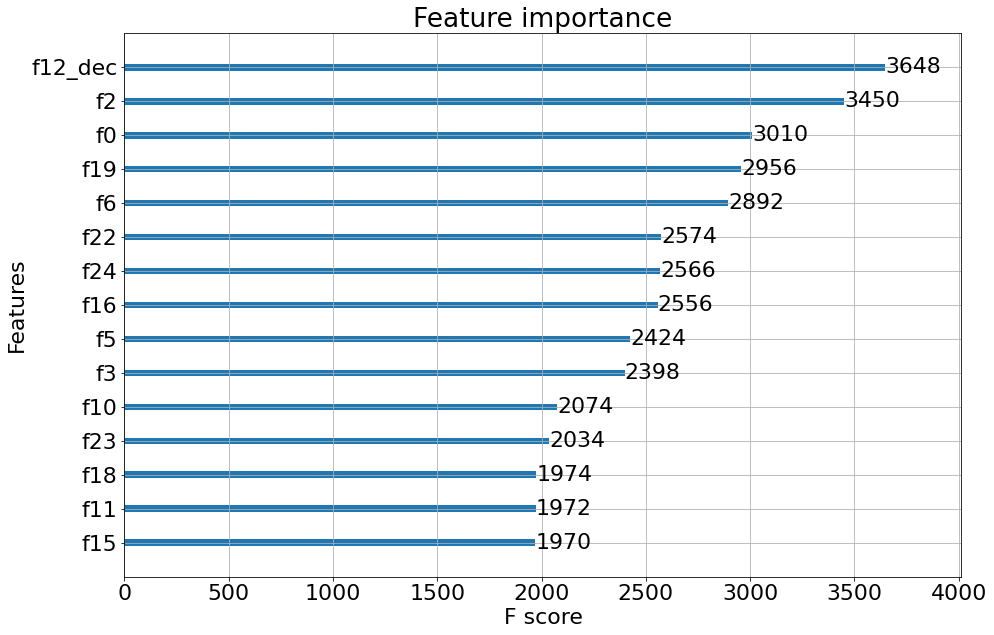

In [35]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 22})
rcParams['figure.figsize'] = 15,10

xgb.plot_importance(model, max_num_features=15)
pyplot.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.312997 to fit


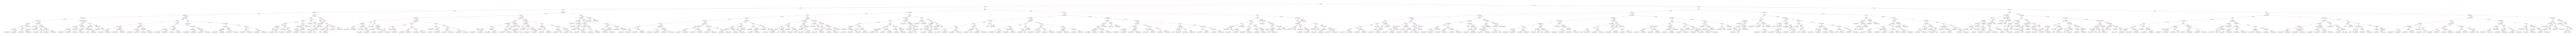

In [37]:
rcParams['figure.figsize'] = 100,100
xgb.plot_tree(model)
pyplot.show()

In [ ]:
model.save_model('xgboost_model.json')